# Test: open all ageing; GITT; contact resistance; hystries etc. 

In [28]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import random;import time, signal
fs=10;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

import sys  
str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P2"))
sys.path.append(str_path_1) 
from Fun_P2 import * 
# pb.set_logging_level("INFO")

In [29]:
model = pb.lithium_ion.DFN(
    options={
        "thermal": "lumped",
        "SEI": "interstitial-diffusion limited",
        "SEI on cracks": "true",
        "SEI film resistance": "distributed", 
        "SEI porosity change": "true",
        "particle mechanics": ("swelling and cracking", "swelling only"),
        "loss of active material": "stress-driven",
        "lithium plating": "partially reversible",
        "contact resistance": "true",
        "open circuit potential": "current sigmoid",
    }
)
param = pb.ParameterValues("OKane2023")
# param.update({"Negative electrode porosity": 0.1})
# Adjust SEI parameters
param.update({"Inner SEI lithium interstitial diffusivity [m2.s-1]": 3e-19})
# Override SEI thickness dependence of lithium plating
param.update({"Dead lithium decay rate [s-1]": 1e-6})
param.update({"Lithium plating kinetic rate constant [m.s-1]": 1e-10})
# Adjust mechanical degradation parameters
param.update({"Negative electrode cracking rate": 1e-22})
param.update({"Negative electrode LAM constant proportional term [s-1]": 1e-9})
param.update({"Positive electrode LAM constant proportional term [s-1]": 1e-9})

c_e = model.variables["Electrolyte concentration [mol.m-3]"]
T = model.variables["Cell temperature [K]"]
D_e = model.param.D_e_dimensional
kappa_e = model.param.kappa_e_dimensional
model.variables["Electrolyte diffusivity [m2.s-1]"] = D_e(c_e, T)
model.variables["Electrolyte conductivity [S.m-1]"] = kappa_e(c_e, T)
# use electrolyte
V_max = 4.2;        V_min = 2.5; 
exp_RPT_0p1C_text = [ (
    f"Discharge at 1 C until {V_min} V (1 minute period)", #  (1 minute period)  
    "Rest for 1 hours (5 minute period)",  
    f"Charge at 1 C until {V_max} V (1 minute period)",
    "Rest for 1 hours (5 minute period)",
    ) ]
exp_RPT_refill_text = [ (
    f"Charge at 0.3C until {V_max} V",  
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours (5 minute period)",  
    ) ]
exp_RPT_GITT_text = [ (
    "Rest for 60 seconds (0.1 second period)",  
    f"Discharge at C/2 for 4.8 minutes or until {V_min}V (0.1 second period)",
    "Rest for 1 hour (5 minute period)",  
    ) ]
# how to get 0.1s Resistance: voltage: mean of rest step [-10:-1] data points; don't include the last data points of rest step!;
# should also get OCV and SOC 
Experiment_Breakin= pb.Experiment( exp_RPT_0p1C_text * 1 +  exp_RPT_refill_text*1 +   exp_RPT_GITT_text*24 )
var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator 
    "x_p": 5,  # positive electrode
    "r_n": 30,  # negative particle
    "r_p": 20,  # positive particle
}


2023-03-12 21:56:56.355 - [INFO] base_model._build_model(550): Start building Doyle-Fuller-Newman model
2023-03-12 21:56:56.455 - [INFO] base_battery_model.build_model(975): Finish building Doyle-Fuller-Newman model


In [30]:
# now go for Landes constant:
param.update({"Electrolyte conductivity [S.m-1]": electrolyte_conductivity_EC_EMC_3_7_Landesfeind2019_Constant})
param.update({"Electrolyte diffusivity [m2.s-1]": electrolyte_diffusivity_EC_EMC_3_7_Landesfeind2019_Constant})
param.update({"1 + dlnf/dlnc": electrolyte_TDF_EC_EMC_3_7_Landesfeind2019_Constant})
param.update({"Cation transference number": electrolyte_transference_number_EC_EMC_3_7_Landesfeind2019_Constant})
sim2 = pb.Simulation(
    model, 
    experiment=Experiment_Breakin,
    parameter_values=param,
    solver=pb.CasadiSolver(return_solution_if_failed_early=True),
    var_pts=var_pts,
)
solution_Landes_constant = sim2.solve()

2023-03-12 21:56:56.600 - [INFO] callbacks.on_experiment_start(166): Start running experiment
2023-03-12 21:56:56.601 - [INFO] parameter_values.process_model(425): Start setting parameters for Doyle-Fuller-Newman model
2023-03-12 21:56:56.947 - [INFO] parameter_values.process_model(527): Finish setting parameters for Doyle-Fuller-Newman model
2023-03-12 21:56:56.965 - [INFO] parameter_values.process_model(425): Start setting parameters for Doyle-Fuller-Newman model
2023-03-12 21:56:57.186 - [INFO] parameter_values.process_model(527): Finish setting parameters for Doyle-Fuller-Newman model
2023-03-12 21:56:57.189 - [INFO] parameter_values.process_model(425): Start setting parameters for Doyle-Fuller-Newman model
2023-03-12 21:56:57.436 - [INFO] parameter_values.process_model(527): Finish setting parameters for Doyle-Fuller-Newman model
2023-03-12 21:56:57.439 - [INFO] parameter_values.process_model(425): Start setting parameters for Doyle-Fuller-Newman model
2023-03-12 21:56:57.638 - [I

In [31]:
#model.variables.search("SEI")

9.82124881763119 39.52880335146209


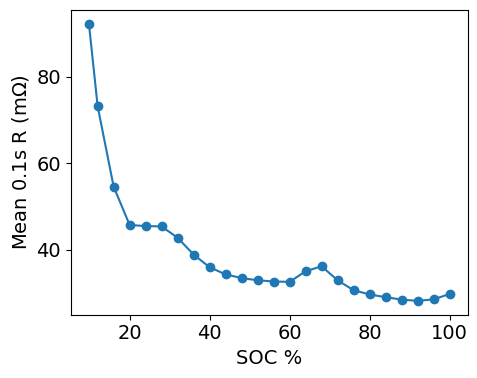

In [39]:
# write a function to get the discharge capacity and resistance
def Get_0p1s_R0(sol_RPT,Index,cap_full):
    Res_0p1s = []; SOC = [100,];
    for i,index in enumerate(Index):
        cycle = sol_RPT.cycles[index]
        Res_0p1s.append(   (
            np.mean(cycle.steps[0]["Terminal voltage [V]"].entries[-10:-1])
            - cycle.steps[1]["Terminal voltage [V]"].entries[0]
        ) / cycle.steps[1]["Current [A]"].entries[0] * 1000)
        if i > 0:
            Dis_Cap = abs(
                cycle.steps[1]["Discharge capacity [A.h]"].entries[0] 
                - cycle.steps[1]["Discharge capacity [A.h]"].entries[-1] )
            SOC.append(SOC[-1]-Dis_Cap/cap_full*100)
    return np.mean(Res_0p1s),Res_0p1s,SOC
cap_full = 5;
Index = np.arange(2,26,1) # index = 2:25
Mean_Res_0p1s,Res_0p1s,SOC = Get_0p1s_R0(solution_Landes_constant,Index,cap_full)

fs=14;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

fig, ax = plt.subplots( figsize=(5,4),tight_layout=True)
ax.plot(SOC,Res_0p1s,"-o")
ax.set_xlabel("SOC %")
ax.set_ylabel(r'Mean 0.1s R (m$\Omega$)')
print(SOC[-1],Mean_Res_0p1s)

In [ ]:
label = [
    "Step-0",
    "Step-1",
    "Step-2",] 
var = [
    "Terminal voltage [V]",
    "Current [A]",
    "Electrolyte concentration [mol.m-3]",
    "Electrolyte diffusivity [m2.s-1]",
    "Electrolyte conductivity [S.m-1]",
    "X-averaged SEI interfacial current density [A.m-2]",
]
quick_plot = pb.QuickPlot(
    [
    solution_Landes_constant.cycles[0],
    solution_Landes_constant.cycles[1],
    solution_Landes_constant.cycles[2],
    ], var,label,variable_limits='tight') #     
quick_plot.dynamic_plot();

In [ ]:
len(solution_Landes_constant.cycles)

In [ ]:

var = [
    "Terminal voltage [V]",
    "Current [A]",
    "Electrolyte concentration [mol.m-3]",
    "Electrolyte diffusivity [m2.s-1]",
    "Electrolyte conductivity [S.m-1]",
    "X-averaged SEI interfacial current density [A.m-2]",
]
quick_plot = pb.QuickPlot(
    [cycle for cycle in solution_Landes_constant.cycles[2:-1]],
    var,variable_limits='tight') #     
quick_plot.dynamic_plot();